1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [1]:
!wget 'https://drive.google.com/uc?id=1a47_w6J2G2k_IQNCaPX5JO56-4qfM1pJ' -O data.csv

--2023-07-13 13:13:18--  https://drive.google.com/uc?id=1a47_w6J2G2k_IQNCaPX5JO56-4qfM1pJ
Resolving drive.google.com (drive.google.com)... 142.250.180.206
Connecting to drive.google.com (drive.google.com)|142.250.180.206|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/17n3ok6q39j7v30gdao0ckpvuccvi6n5/1689246750000/14904333240138417226/*/1a47_w6J2G2k_IQNCaPX5JO56-4qfM1pJ?uuid=16e1aa96-8525-49ba-9fff-97b69e21891e [following]
--2023-07-13 13:13:19--  https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/17n3ok6q39j7v30gdao0ckpvuccvi6n5/1689246750000/14904333240138417226/*/1a47_w6J2G2k_IQNCaPX5JO56-4qfM1pJ?uuid=16e1aa96-8525-49ba-9fff-97b69e21891e
Resolving doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleusercontent.com)... 142.250.180.225
Connecting to doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleuserc

In [2]:
!pip install scikit-uplift catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 536.8 kB/s eta 0:00:00 0:00:01


In [3]:
import numpy as np 
import pandas as pd 

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
from sklift.models import ClassTransformation
from sklift.models import TwoModels

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


2. поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [4]:
df = pd.read_csv('data.csv', sep=',')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [5]:
df.rename(columns={'offer':'treatment', 'conversion':'target'}, inplace=True)
df['treatment'] = df['treatment'].apply(lambda x: 0 if x == 'No Offer' else 1)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [6]:
cat_feature = ['zip_code', 'channel']

3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [7]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'),
                                                    df['target'],
                                                    test_size=0.25,  
                                                    random_state=7575,
                                                    stratify=df['target'])

treat_train = X_train['treatment']
X_train.drop(columns=['treatment'], inplace=True)
treat_val = X_test['treatment']
X_test.drop(columns='treatment', inplace=True)

4. провести uplift-моделирование 3 способами:
    1. одна модель с признаком коммуникации (S-learner)
    2. модель с трансформацией таргета
    3. вариант с двумя независимыми моделями

In [8]:
metrics_df = pd.DataFrame(columns=['model', 'uplift@10%', 'uplift@20%', 'uplift@30%'])
metrics_df

,model,uplift@10%,uplift@20%,uplift@30%


### A. Подход с одной моделью

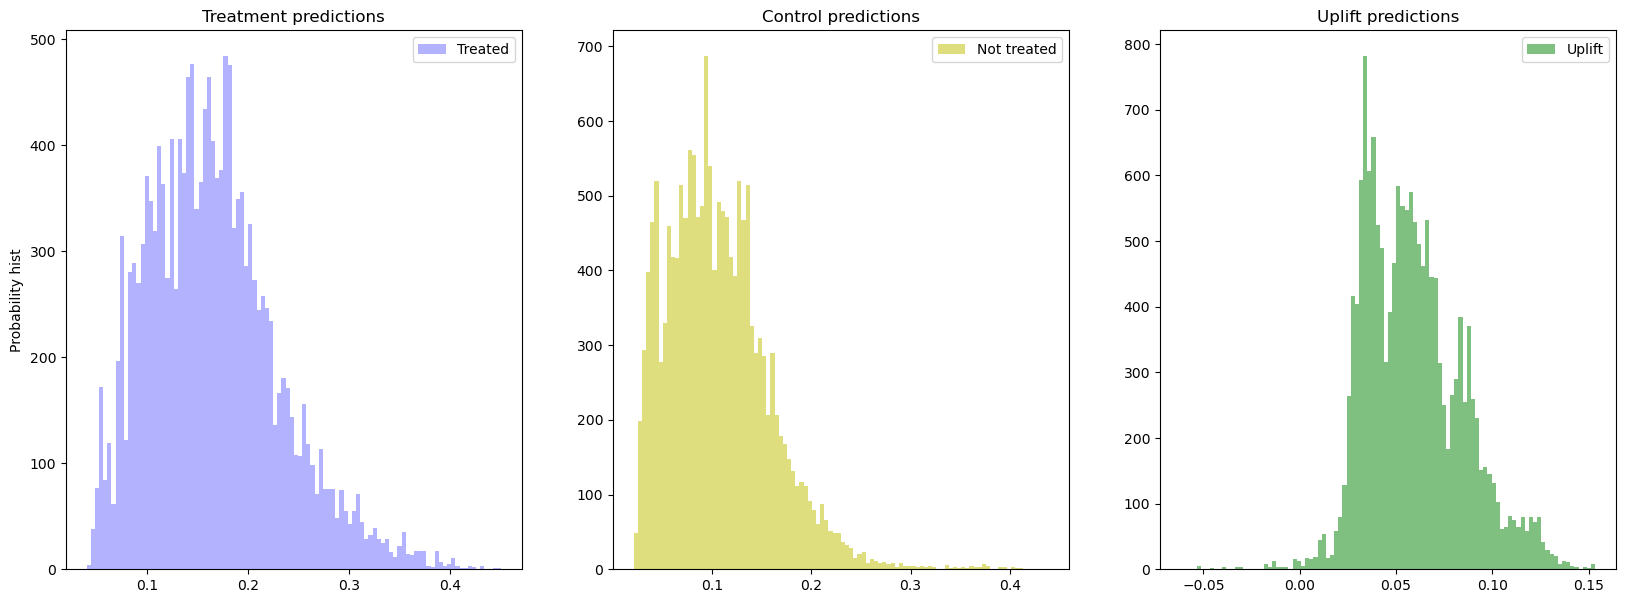

In [9]:
sm = SoloModel(CatBoostClassifier(iterations=50, random_state=7575, silent=True, cat_features=cat_feature))

sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

df = {'model': type(sm).__name__,'uplift@10%': sm_score_10,'uplift@20%': sm_score_20, 'uplift@30%': sm_score_30}
df = pd.DataFrame.from_dict(df, orient='index').T

metrics_df = pd.concat([metrics_df, df], axis = 0).reset_index(drop=True)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [10]:
df

,model,uplift@10%,uplift@20%,uplift@30%
0,SoloModel,0.074109,0.071905,0.073349


### B. Трансформация классов

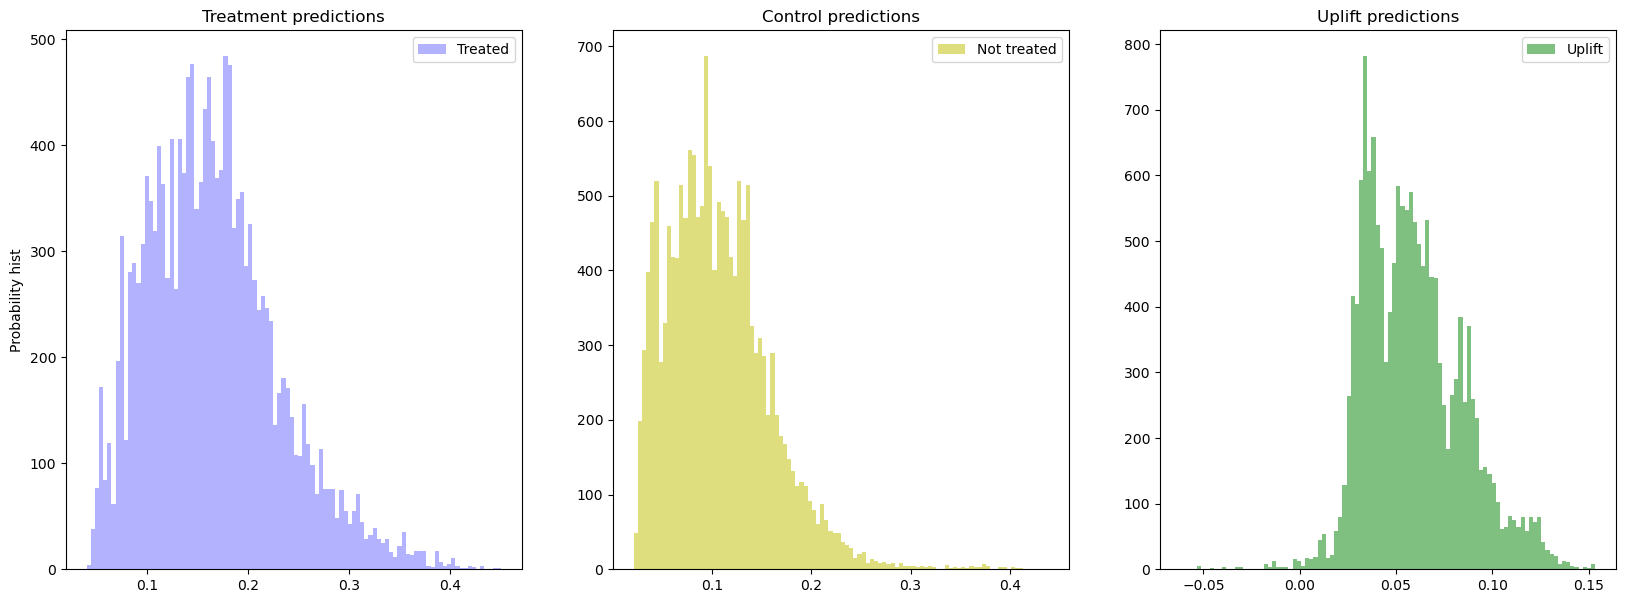

In [11]:
ct = ClassTransformation(CatBoostClassifier(iterations=50, random_state=7575, silent=True, cat_features=cat_feature))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

df = {'model': type(ct).__name__,'uplift@10%': ct_score_10,'uplift@20%': ct_score_20, 'uplift@30%': ct_score_30}
df = pd.DataFrame.from_dict(df, orient='index').T
metrics_df = pd.concat([metrics_df, df], axis = 0).reset_index(drop=True)

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm.trmnt_preds_, ctrl_preds=sm.ctrl_preds_);

In [12]:
df

,model,uplift@10%,uplift@20%,uplift@30%
0,ClassTransformation,0.106004,0.072372,0.072411


### C. Две независимые модели

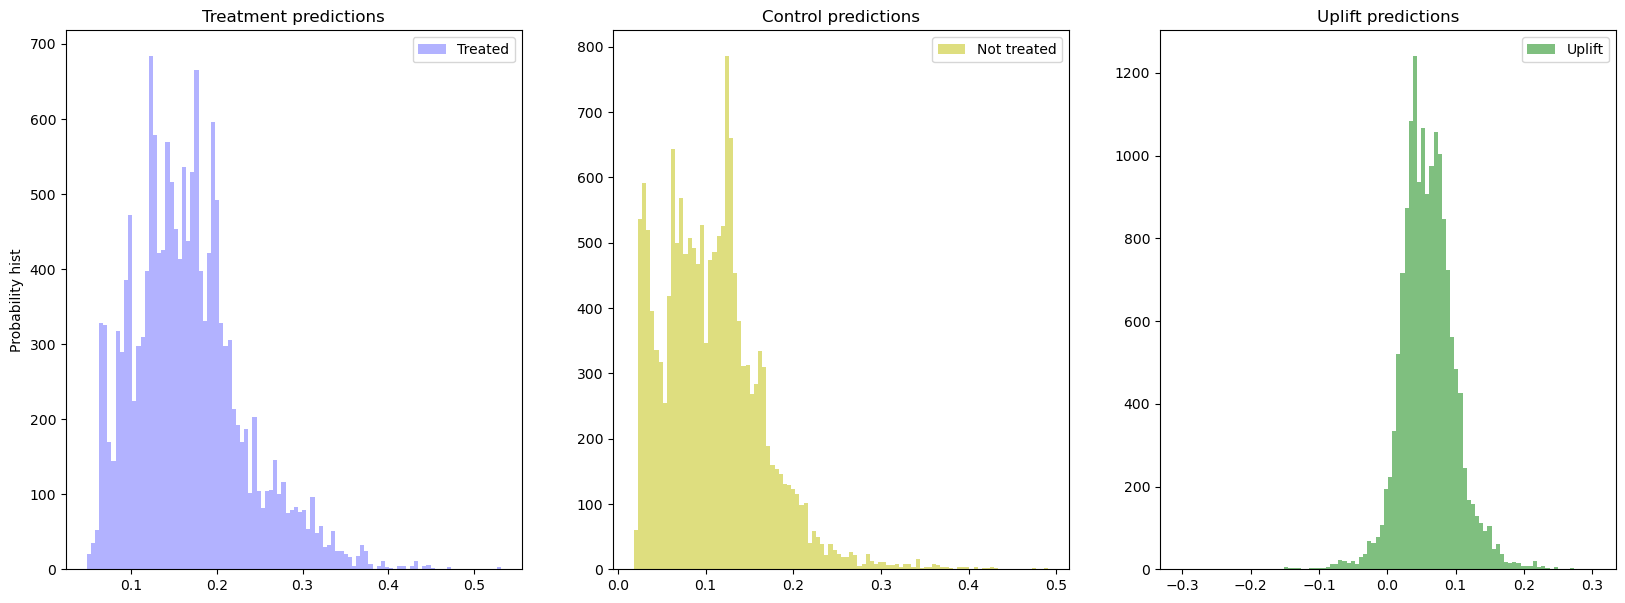

In [13]:
tm = TwoModels(
    CatBoostClassifier(iterations=50, random_state=7575, silent=True, cat_features=cat_feature),
    CatBoostClassifier(iterations=50, random_state=7575, silent=True, cat_features=cat_feature),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

df = {'model': type(tm).__name__,'uplift@10%': tm_score_10,'uplift@20%': tm_score_20, 'uplift@30%': tm_score_30}
df = pd.DataFrame.from_dict(df, orient='index').T
metrics_df = pd.concat([metrics_df, df], axis = 0).reset_index(drop=True)


plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [14]:
df

,model,uplift@10%,uplift@20%,uplift@30%
0,TwoModels,0.082552,0.065332,0.061457


5. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей

In [15]:
metrics_df

,model,uplift@10%,uplift@20%,uplift@30%
0,SoloModel,0.074109,0.071905,0.073349
1,ClassTransformation,0.106004,0.072372,0.072411
2,TwoModels,0.082552,0.065332,0.061457



6. *для модели S-learner построить зависимость таргета (конверсии - поле conversion) от значения uplift:
    1. сделать прогноз и получить uplift для тестовой выборки
    2. отсортировать тестовую выборку по uplift по убыванию
    3. разбить на децили (pandas qcut вам в помощь)
    4. для каждого дециля посчитать среднюю conversion

In [16]:
sm = SoloModel(
    CatBoostClassifier(iterations=100, random_state=7575, silent=True, cat_features=cat_feature)
)
sm = sm.fit(X_train, y_train, treat_train)
uplift_sm = sm.predict(X_test)

In [17]:
df_test = X_test.copy()
df_test['pred_uplift'] = uplift_sm
df_test['conversion'] = y_test
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,pred_uplift,conversion
30501,6,128.46,1,0,Urban,1,Phone,0.031235,1
41744,10,121.07,0,1,Surburban,0,Web,0.062516,0
38409,9,98.57,1,0,Rural,1,Phone,0.037940,0
26791,4,94.65,0,1,Surburban,0,Web,0.084628,0
21586,10,202.98,1,1,Surburban,1,Web,0.130600,0


In [18]:
df_test = df_test.sort_values(by='pred_uplift', ascending=False)
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,pred_uplift,conversion
23144,9,230.17,1,1,Urban,0,Web,0.223198,0
46581,2,166.47,0,1,Surburban,0,Web,0.200485,1
53809,11,207.24,1,1,Urban,0,Phone,0.198973,1
14349,11,232.84,1,1,Surburban,0,Web,0.194535,1
20604,10,228.97,1,1,Surburban,0,Phone,0.193786,0


In [19]:
df_test['deciles'] = pd.qcut(df_test['pred_uplift'], q=10, labels=False)
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,pred_uplift,conversion,deciles
23144,9,230.17,1,1,Urban,0,Web,0.223198,0,9
46581,2,166.47,0,1,Surburban,0,Web,0.200485,1,9
53809,11,207.24,1,1,Urban,0,Phone,0.198973,1,9
14349,11,232.84,1,1,Surburban,0,Web,0.194535,1,9
20604,10,228.97,1,1,Surburban,0,Phone,0.193786,0,9


In [20]:
for i in range(0, 10):
    tmp = df_test[df_test['deciles'] == i]
    print(f'Для дециля {i} средняя конверсия равна {tmp["conversion"].mean():.3f}')

Для дециля 0 средняя конверсия равна 0.124
Для дециля 1 средняя конверсия равна 0.126
Для дециля 2 средняя конверсия равна 0.126
Для дециля 3 средняя конверсия равна 0.129
Для дециля 4 средняя конверсия равна 0.121
Для дециля 5 средняя конверсия равна 0.141
Для дециля 6 средняя конверсия равна 0.151
Для дециля 7 средняя конверсия равна 0.164
Для дециля 8 средняя конверсия равна 0.159
Для дециля 9 средняя конверсия равна 0.227
